# Correlation plots

start by running all the cells down to [here](#read-in-data)

In [315]:
from pathlib import Path

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from pandas.io.formats.style import Styler
import scipy.stats
import seaborn as sns

rc = mpl.rc_params_from_file(mpl.matplotlib_fname(), use_default_template=False)
sns.set_theme(style="white", rc=rc)

def rogi_rmse_corr(df):
    rogi = df["ROGI"].values
    errors = df["RMSE"].values
    r, p = scipy.stats.pearsonr(rogi, errors)
    
    return r or 0

def read_data(json_dir: Path):
    dfs = [pd.read_json(p) for p in json_dir.iterdir()]
    df = pd.concat(dfs, ignore_index=True)\
        .rename(
            columns={
                "dataset_and_task": "dataset",
                "rogi": "ROGI",
                "rmse": "RMSE",
            }
        )\
        .replace("morgan", "fp")\
        .sort_values(["model", "dataset", "representation"])
    
    return df


def process_data(df: pd.DataFrame, include_extra_rand: bool = False):
    df = df[~df.representation.str.contains('_reinit')]
    if not include_extra_rand:
        df = df[df.representation != "random256"]
        df = df[df.representation != "random512"]

    df = df.drop(["thresholds", "cg_sds", "n_clusters"], axis=1)
    s_corr = df.groupby(["dataset", "model"]).apply(rogi_rmse_corr).fillna(0).rename("r")
    
    return df, s_corr


MARKERS = ['o', 'X', 's', 'P', 'D', (4, 1, 0), "^", (4, 1, 45), (5, 1, 0), (5, 1, 60), (6, 1, 0)]
REP_LABELS = dict(
    fp="FP",
    vae="VAE",
    gin="GIN",
    chemberta="ChemBERTa",
    chemgpt="ChemGPT",
    random128=r"$\mathrm{rand}^{128}$",
    random256=r"$\mathrm{rand}^{256}$",
    random512=r"$\mathrm{rand}^{512}$"
)

## Plotting functions

In [307]:
def plot_corr_models(s_corr: pd.Series, ax: plt.Axes = None):
    ax = ax or plt.gca()

    datasets = s_corr.index.unique(0).tolist()
    models = s_corr.index.unique(1).tolist()
    model_colors = sns.color_palette('deep', len(models))

    Y = s_corr.values.reshape(len(datasets), len(models))
    JITTER = 0.1

    bp = ax.boxplot(
        Y,
        vert=True,
        labels=models,
        widths=0.5,
        showmeans=True,
        patch_artist=True,
        boxprops=dict(lw=1.5, fc="None"),
        medianprops=dict(c=None),
        capprops=dict(lw=1.5),
        showfliers=False,
    )

    for median, c in zip(bp['medians'], model_colors):
        median.set_color(c)

    for j in range(Y.shape[1]):
        y = Y[:, j]
        x = (j + 1) + np.random.uniform(-JITTER, JITTER, y.shape)

        ax.plot(x, y, MARKERS[j], c=model_colors[j], mew=1.5, ms=7.5)
    # ax.scatter(x, y, 50, DATASET_COLORS, MARKERS[j], edgecolor='k', linewidth=1.5)

    ax.grid(False, axis='x')
    ax.set_ylim(-1.05, 1.05)
    ax.set_xlabel("Model")
    ax.set_ylabel(r"$r$")
    

def plot_corr_dataset(s_corr: pd.Series, ax: plt.Axes = None):
    ax = ax or plt.gca()

    datasets = s_corr.index.unique(0).tolist()
    models = s_corr.index.unique(1).tolist()
    dataset_colors = sns.color_palette('pastel', len(datasets))

    ax = sns.scatterplot(
        s_corr.reset_index(), y='dataset', x="r", hue='dataset', palette=dataset_colors, 
        style="model", markers=MARKERS, style_order=models,
        edgecolor="k", linewidth=1., s=33,
        legend=False, ax=ax
    )

    ax.set_xlim(-1.05, 1.05)
    ax.grid(False, axis='y')
    ax.set_ylabel("Dataset")
    ax.set_xlabel(r"$r$")
    ax.tick_params(axis='y', labelsize=8)

    legend_elements = [
        Line2D([0], [0], marker=marker, ls='', color='k', mfc='None', mew=1.5, label=model)
        for marker, model in zip(MARKERS, models)
    ]

    ax.legend(
        handles=legend_elements,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.0),
        facecolor="w",
        fontsize=8,
        ncols=len(models)
    )


def plot_corr_single(df: pd.DataFrame, model: str, dataset: str, ax = None):
    ax = ax or plt.gca()

    df_temp = df.query(f"model == '{model}' & dataset == '{dataset}'")
    reprs, xs, ys = df_temp.representation.values, df_temp.ROGI.values, df_temp.RMSE.values

    for r, x, y, m in zip(reprs, xs, ys, MARKERS):
        ax.scatter(x, y, marker=m, edgecolor="k", linewidth=1, label=REP_LABELS.get(r, r))

    res = scipy.stats.linregress(xs, ys)

    print(f"p: {res.pvalue:0.3f}")
    
    x = np.array(xs)
    y = res.slope * x + res.intercept
    ax.plot([x.min(), x.max()], [y.min(), y.max()], '--', color="darkgrey")

    ax.text(0.03, 0.97, rf"$r={res.rvalue:0.2f}$", ha="left", va="top", transform=ax.transAxes)
    ax.tick_params(direction="out", left=True, bottom=True)
    ax.set_xlabel("ROGI")
    ax.set_ylabel("RMSE")

    return ax

def plot_corr_all(df: pd.DataFrame):
    facetprops = dict(despine=False, sharex=False, sharey=False)

    g = sns.relplot(
        df,
        x="ROGI", y="RMSE", col="model", row="dataset",
        hue="representation", style="representation", palette="muted",
        height=4, legend="auto", facet_kws=facetprops,
        edgecolor='k', linewidth=1.5, s=100, ci=None
    )

    for ax in g.axes.flat:
        ax.grid(True, ls="--")

    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    return g

## Read in data

run all the cells above first! Then, set `JSON_DIR` to the directory containing the output cross-validation JSON files for all representations. Finally, run the corresponding cell for the desired figure

In [316]:
VERSION = "v1"
JSON_DIR = Path(f"../results/raw/cv/tdc+guac_{VERSION}")

df = read_data(JSON_DIR)
df, s_corr = process_data(df)
df

,representation,dataset,ROGI,n_valid,model,r2,RMSE,mae
75,chemberta,ARIPIPRAZOLE_SIMILARITY,0.224108,10000,KNN,0.210001,0.117511,0.093841
245,chemgpt,ARIPIPRAZOLE_SIMILARITY,0.215322,10000,KNN,0.244761,0.114906,0.091574
500,descriptor,ARIPIPRAZOLE_SIMILARITY,0.168301,10000,KNN,0.697986,0.072650,0.056787
160,fp,ARIPIPRAZOLE_SIMILARITY,0.033185,10000,KNN,0.580140,0.085665,0.066644
585,random128,ARIPIPRAZOLE_SIMILARITY,0.158584,10000,KNN,-0.167321,0.142863,0.113663
...,...,...,...,...,...,...,...,...
73,chemberta,ZALEPLON_MPO,0.359823,10000,SVR,0.213115,0.181753,0.134866
243,chemgpt,ZALEPLON_MPO,0.349013,10000,SVR,0.229079,0.179918,0.128377
498,descriptor,ZALEPLON_MPO,0.292480,10000,SVR,0.519197,0.142044,0.101720
158,fp,ZALEPLON_MPO,0.078294,10000,SVR,0.273291,0.174635,0.134251


In [317]:
df.groupby(["dataset", "model"]).apply(rogi_rmse_corr)

dataset                  model
ARIPIPRAZOLE_SIMILARITY  KNN      0.409751
                         MLP     -0.084629
                         PLS      0.709027
                         RF       0.488843
                         SVR      0.331254
                                    ...   
ZALEPLON_MPO             KNN      0.034842
                         MLP     -0.271877
                         PLS      0.431148
                         RF      -0.012252
                         SVR     -0.042977
Length: 85, dtype: float64

## Marginalized correlation distributions

/tmp/ipykernel_3402613/4246736091.py:47: UserWarning: The markers list has more values (11) than needed (5), which may not be intended.
  ax = sns.scatterplot(


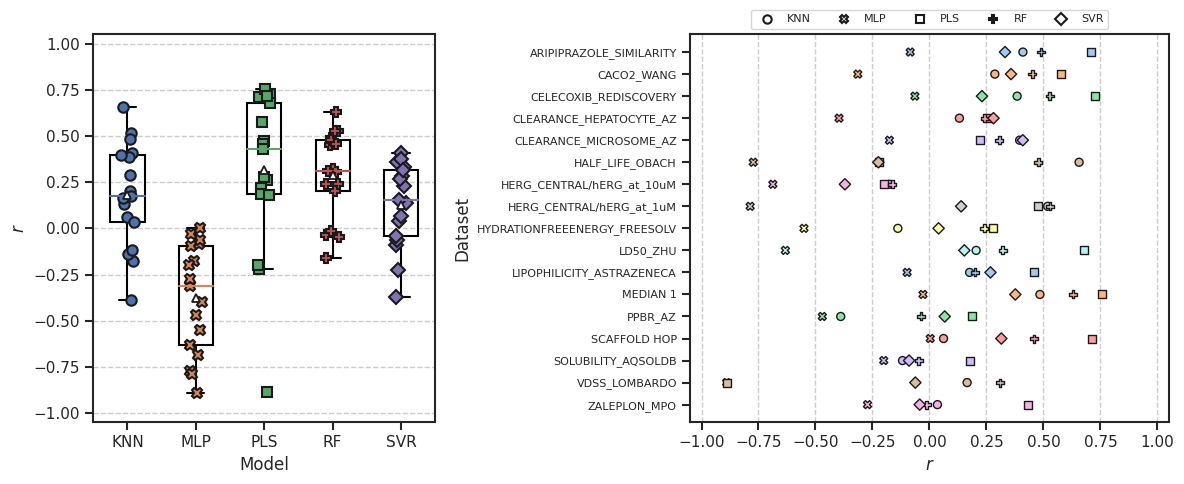

In [318]:
fig, label2ax = plt.subplot_mosaic([['models', 'datasets']], width_ratios=[5, 7], figsize=(12, 5))

plot_corr_models(s_corr, label2ax['models'])
plot_corr_dataset(s_corr, label2ax['datasets'])

fig.tight_layout()    

In [261]:
fig.savefig(
    f"../results/figures/correlation/model-dataset_{VERSION}.pdf", bbox_inches="tight"
)

## Correlation plots

### Single correlation plot



p: 0.037


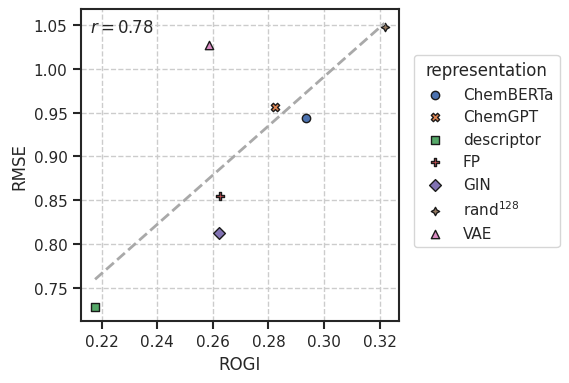

In [275]:
fig, ax = plt.subplots(figsize=(4.25, 4))
plot_corr_single(df, "SVR", "ZALEPLON_MPO", ax)

fig.legend(title="representation", loc="center left", bbox_to_anchor=(0.975, 0.6))
fig.tight_layout()

In [263]:
fig.savefig(
    f"../results/figures/correlation/zaleplon-svr_{VERSION}.pdf",
    bbox_inches="tight"
)

### ALL plots

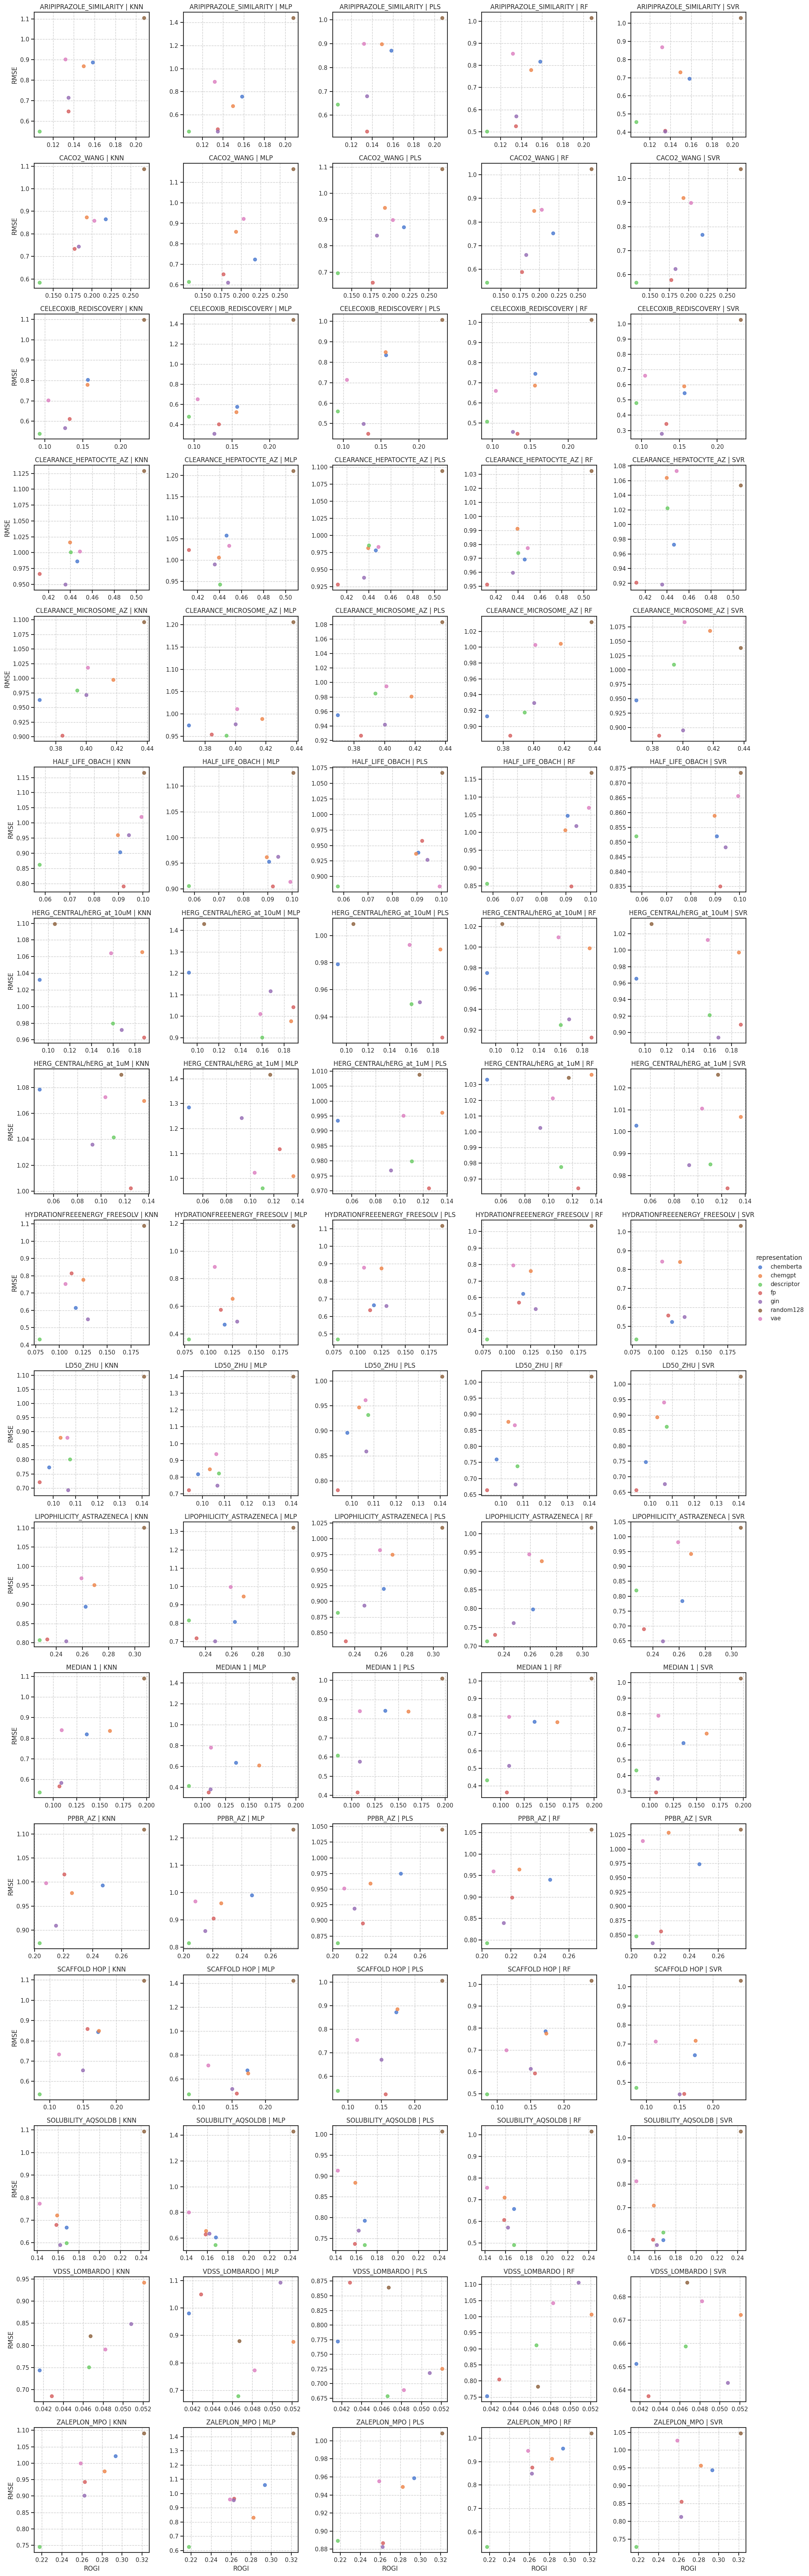

In [285]:
g = plot_corr_all(df)

In [265]:
g.savefig(f"../results/figures/correlation/all_{VERSION}.pdf", bbox_inches="tight")

---
## GRAVEYARD
---

In [ ]:
TABLE_FILE.parent.mkdir(exist_ok=True, parents=True)

Styler(
    df.groupby(["dataset_and_task", 'range', "model"])\
        .mean()\
        .rename_axis(index={"dataset_and_task": "dataset"})\
        .rename(index=lambda s: s.lower().capitalize(), level=0),
    precision=3
)\
.format_index(escape="latex", axis=0, precision=3)\
.format_index(escape="latex", axis=1)\
.hide(axis=0, level=-1)\
.hide(["rogi", "r2", "rmse", "mae"], axis=1)\
.to_latex(TABLE_FILE, hrules=True, sparse_columns=True)

Optionally, save the results to a CSV

In [ ]:
df.reset_index().to_csv(TABLE_FILE.with_suffix(".csv"), index=False, float_format="%0.3f")

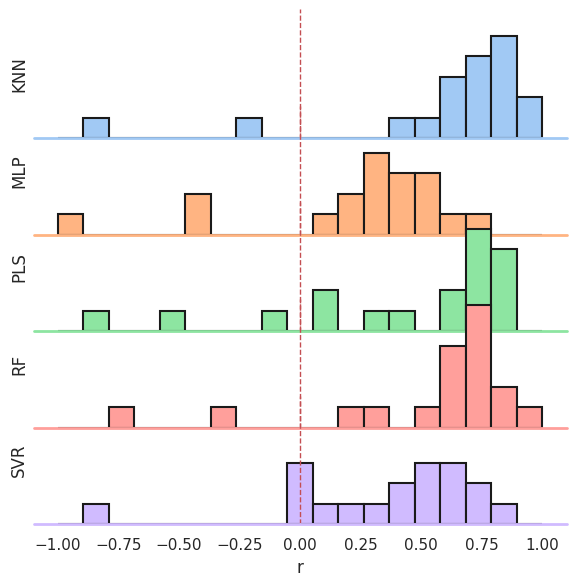

In [ ]:
g = sns.FacetGrid(
    df_grouped.reset_index(), row='model', hue='model', aspect=5, height=1.25, palette=MODEL_COLORS,
    sharey=True, sharex=True
)

g.map(
    sns.histplot, 'r',
    clip_on=False, alpha=1, linewidth=1.5, bins=np.linspace(-1, 1, 20), edgecolor='k'
)

g.map(plt.axvline, x=0, lw=1, ls="--", c="r", clip_on=False)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(MODELS[i])

g.fig.subplots_adjust(hspace=-0.25)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g

/home/degraff/.conda/envs/pcmr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/degraff/.conda/envs/pcmr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


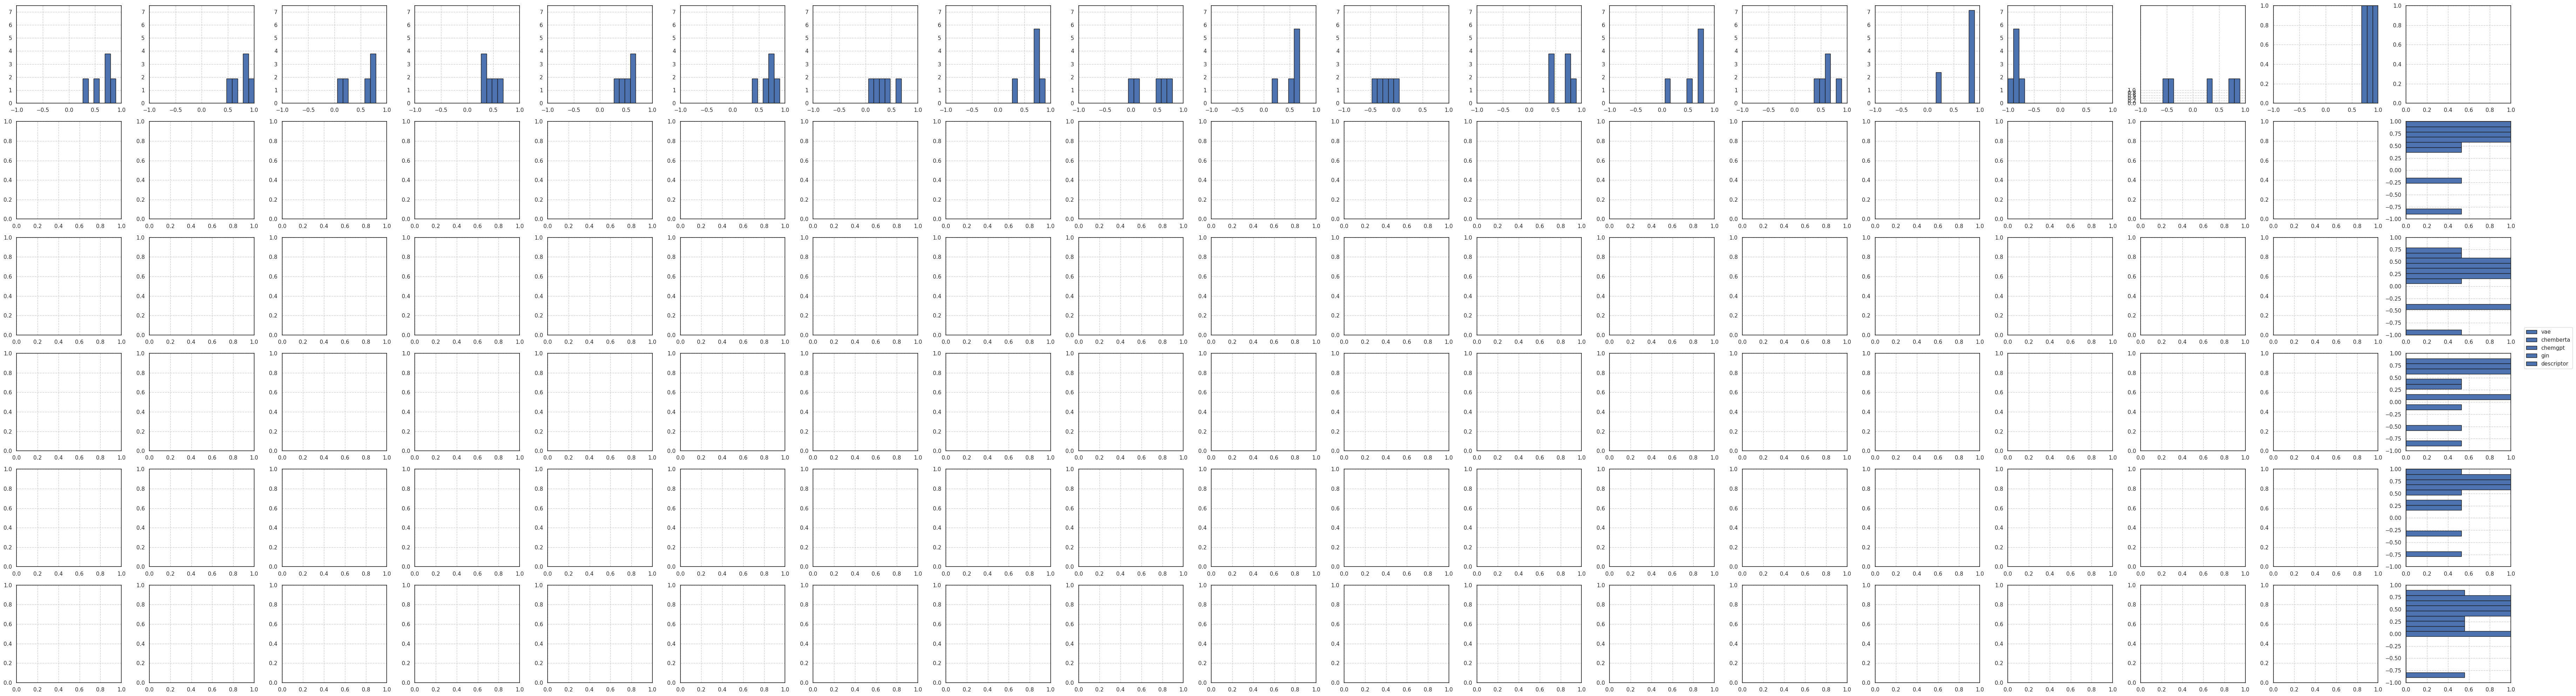

In [ ]:
df = df.sort_values(["model", "dataset", "features"])

MODELS = df["model"].unique()
DATASETS = df["dataset"].unique()
colors = sns.color_palette("deep", 5)
markers = ['o', 'X', 'P', 's', 'D']

nrows = len(MODELS)
ncols = len(DATASETS)
fig, axs = plt.subplots(
    nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharex=False, sharey=False
)

def corr_plot(ax: plt.Axes, xs, ys, markers, colors, labels):
    BUFFER = 0.03

    for x, y, m, c, l in zip(xs, ys, markers, colors, labels):
        ax.scatter(x, y, 50, marker=m, color=c, edgecolors='k', label=l)

    r, _ = scipy.stats.pearsonr(xs, ys)
    s = rf"$r = {r:0.3f}$"
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='none')
    ax.text(
        0 + BUFFER, 1 - BUFFER, s,
        ha="left", va="top", fontsize=10, transform=ax.transAxes, bbox=bbox
    )
    
    ax.grid(True)


for i, model in enumerate(MODELS):   
    for j, dset in enumerate(DATASETS):

        s = df.query(f"model == '{model}' and dataset == '{dset}'")
        corr_plot(
            axs[i+1, j], s["ROGI"].values, s["RMSE"].values, markers, colors, s.features
        )

        axs[i, j].set_title(f"{model} | {dset}")

fig.legend(s.features, loc='center left', bbox_to_anchor=(1.0, 0.5))
# fig.subplots_adjust(wspace=1)
# fig.supxlabel(r"$N_{\mathrm{clusters}} / N$", fontsize=16)
# fig.supylabel(r"$2(\sigma_0 - \sigma_t)$", x=0.01, fontsize=16)

fig.tight_layout()